In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import math
import glob
import mplhep as hep
hep.style.use("CMS")
hep.style.use(hep.style.CMS)

In [2]:
def calculate_number_particle_hits(data_dir):
   
    file_list = np.sort(glob.glob(data_dir+'*root'))
    
    # Lists to hold info for all files
    genP = []
    num_particles_in_zdc = []
    lambda_decay_vertexZ_list = []
    
    # ZDC front face position
    zdc_zmin = 3580.0 # in cm

    # The dimensions of the ZDC acceptance
    # The ZDC is roughly 60x60 cm^2, but the acceptance is 40x40 cm^2 due to magnets
    zdc_acceptance_width = 40. # in cm
    zdc_acceptance_height = 40. # in cm
    zdc_xmin = -zdc_acceptance_width/2. # in cm
    zdc_xmax = zdc_acceptance_width/2. # in cm
    zdc_ymin = -zdc_acceptance_height/2. # in cm
    zdc_ymax = zdc_acceptance_height/2. # in cm
    
    # Looping through all the files and counting the number of particles that hit the ZDC, and the event energy
    for file_name in file_list:
        with ur.open("{file}:events".format(file=file_name)) as events:
            zdc_MC = events.arrays(["MCParticles.generatorStatus", "MCParticles.PDG",
                                    'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z',
                                    'MCParticles.vertex.x', 'MCParticles.vertex.y', 'MCParticles.vertex.z', 'MCParticles.endpoint.z'])
            num_entries = events.num_entries
        print("Total Entries = ", num_entries)
        
        final_state_mask = (zdc_MC['MCParticles.generatorStatus'] == 1) # Getting neutron and 2 photons in each event
        genPx = zdc_MC['MCParticles.momentum.x'][final_state_mask]
        genPy = zdc_MC['MCParticles.momentum.y'][final_state_mask]
        genPz = zdc_MC['MCParticles.momentum.z'][final_state_mask]

        # Need to convert vertices to cm to align with above ZDc dimensions
        vertexX = zdc_MC['MCParticles.vertex.x'][final_state_mask]/10.
        vertexY = zdc_MC['MCParticles.vertex.y'][final_state_mask]/10.
        vertexZ = zdc_MC['MCParticles.vertex.z'][final_state_mask]/10.
        # Calculating the x and y positions of the particles at the ZDC front face
        end_x = vertexX + genPx/genPz * (zdc_zmin - vertexZ)
        end_y = vertexY + genPy/genPz * (zdc_zmin - vertexZ)
        
        # Counting the number of particles that hit the ZDC front face
        hits_zdc_mask = (end_x > zdc_xmin) & (end_x < zdc_xmax) & (end_y > zdc_ymin) & (end_y < zdc_ymax)
        hits_zdc_particles = zdc_MC['MCParticles.PDG'][final_state_mask][hits_zdc_mask] # Can use any branch here. Just using PDG in case we want to look at which particles hit the ZDC.
        num_particles_in_zdc_per_event = [len(i) for i in hits_zdc_particles]
        
        # Getting the true energies of the events from the initial lambda particle
        lambda_mask = (zdc_MC['MCParticles.generatorStatus'] == 2) & (zdc_MC["MCParticles.PDG"] == 3122)
        event_genPx = zdc_MC['MCParticles.momentum.x'][lambda_mask]
        event_genPy = zdc_MC['MCParticles.momentum.y'][lambda_mask]
        event_genPz = zdc_MC['MCParticles.momentum.z'][lambda_mask]
        event_genP = ak.flatten(np.sqrt(event_genPx*event_genPx + event_genPy*event_genPy + event_genPz*event_genPz))
        lambda_decay_vertexZ = ak.flatten(zdc_MC["MCParticles.endpoint.z"][lambda_mask])/1000. # Converting to meters
        
        genP.append(event_genP)
        num_particles_in_zdc.append(num_particles_in_zdc_per_event)
        lambda_decay_vertexZ_list.append(lambda_decay_vertexZ)
        
    # Putting all the entries into one big array
    combined_genP = np.concatenate(genP)
    combined_num_particles_in_zdc = np.concatenate(num_particles_in_zdc)
    combined_lambda_decay_vertexZ = np.concatenate(lambda_decay_vertexZ_list)
    
    return combined_genP, combined_num_particles_in_zdc, combined_lambda_decay_vertexZ

In [3]:
data_directory = "/media/miguel/Elements/zdc_data/zdc_lambdadecay_log10discrete_10GeV-250GeV_0.0deg-0.23deg_staggered_h4_04_29_2024/"
event_genP, num_particles_in_zdc, lambda_decay_vertexZ = calculate_number_particle_hits(data_directory)

Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entries =  10000
Total Entri

In [4]:
energy_bins = np.unique(np.round(np.asarray(event_genP)).astype(int))
print(energy_bins)

[ 10  11  12  13  14  16  17  19  21  24  26  29  32  35  39  43  47  52
  57  63  70  77  85  93 103 114 125 138 152 168 185 204 225 248]


In [5]:
def plot_num_particles(energies, num_particles, binning):   
    N_Bins=len(binning)
    row=math.ceil(np.sqrt(N_Bins))
    if (row**2-N_Bins)>row:
        col=row-1
    else:
        col=row
    y_ticks_size=14
    x_ticks_size=14

    fig,axs = plt.subplots(row,col, figsize=(24, 20),sharex=False)#,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0.35)
    energies=np.rint(energies)
    indecies = np.digitize(energies,binning)-1 #Get the bin number each element belongs to.
    indecies=np.where(indecies < 0, 0, indecies) # Returns array with # of entries in each bin [num bin0, num bin1, ..., num N_Bins-1]
    max_count = np.max(np.bincount(indecies)) # Grabs the number of entries that's the most
    slices = np.empty((N_Bins,max_count+1)) # Slices is an array of N_Bins length, each with max_count entries
    slices.fill(np.nan)
    slices_truth=np.empty((N_Bins,max_count+1))
    slices_truth.fill(np.nan)
    
    counter = np.zeros(N_Bins,int) #for getting mean from sum, and incrementing element number in bin                                                                
    
    for i in range(len(energies)):
        bin = indecies[i]
        if (bin>=N_Bins): continue
        slices[bin][counter[bin]] = num_particles[i] #slice_array[bin number][element number inside bin] = pred[i]                                                            
        counter[bin]+=1
    
    counter[counter == 0] = 1
    fraction_three_particle_events = np.zeros(N_Bins)
    fraction_two_particle_events   = np.zeros(N_Bins)
    fraction_one_particle_events   = np.zeros(N_Bins)
    fraction_zero_particle_events  = np.zeros(N_Bins)

    for ii in range(N_Bins):
                                   
        irow=int(ii/col)
        icol=int(ii%col)
        num_particles_per_event = slices[ii].ravel()[~np.isnan(slices[ii].ravel())] 
        for entry in num_particles_per_event:
            if entry == 3:
                fraction_three_particle_events[ii] += 1
            elif entry == 2:
                fraction_two_particle_events[ii] += 1
            elif entry == 1:
                fraction_one_particle_events[ii] += 1
            elif entry == 0:
                fraction_zero_particle_events[ii] += 1
        fraction_three_particle_events[ii] = fraction_three_particle_events[ii] / len(num_particles_per_event) if len(num_particles_per_event) != 0 else 0 
        fraction_two_particle_events[ii]   = fraction_two_particle_events[ii] / len(num_particles_per_event) if len(num_particles_per_event) != 0 else 0 
        fraction_one_particle_events[ii]   = fraction_one_particle_events[ii] / len(num_particles_per_event) if len(num_particles_per_event) != 0 else 0 
        fraction_zero_particle_events[ii]  = fraction_zero_particle_events[ii] / len(num_particles_per_event) if len(num_particles_per_event) != 0 else 0 

        if irow<row:
            
            ax = axs[irow,icol]
            count_particles, bins_particles,_ = ax.hist(slices[ii].ravel(),bins=4,alpha=0.5,range=(-0.5,3.5),color='b',linewidth=8)

            count_particles=count_particles[~np.isnan(count_particles)]
            bins_particles=bins_particles[~np.isnan(bins_particles)]
            binscenters_particles = np.array([0.5 * (bins_particles[i] + bins_particles[i+1]) for i in range(len(bins_particles)-1)])

            ax.set_title("{0} GeV".format(binning[ii]), fontsize=15)
            ax.tick_params(axis='x', labelsize=x_ticks_size)
            ax.tick_params(axis='y', labelsize=y_ticks_size)
        else:
            continue
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Number of particles hitting ZDC acceptance", fontsize=24, labelpad=20)
    plt.ylabel("Entries", fontsize=24, labelpad=20)
            
    return fraction_three_particle_events, fraction_two_particle_events, fraction_one_particle_events, fraction_zero_particle_events

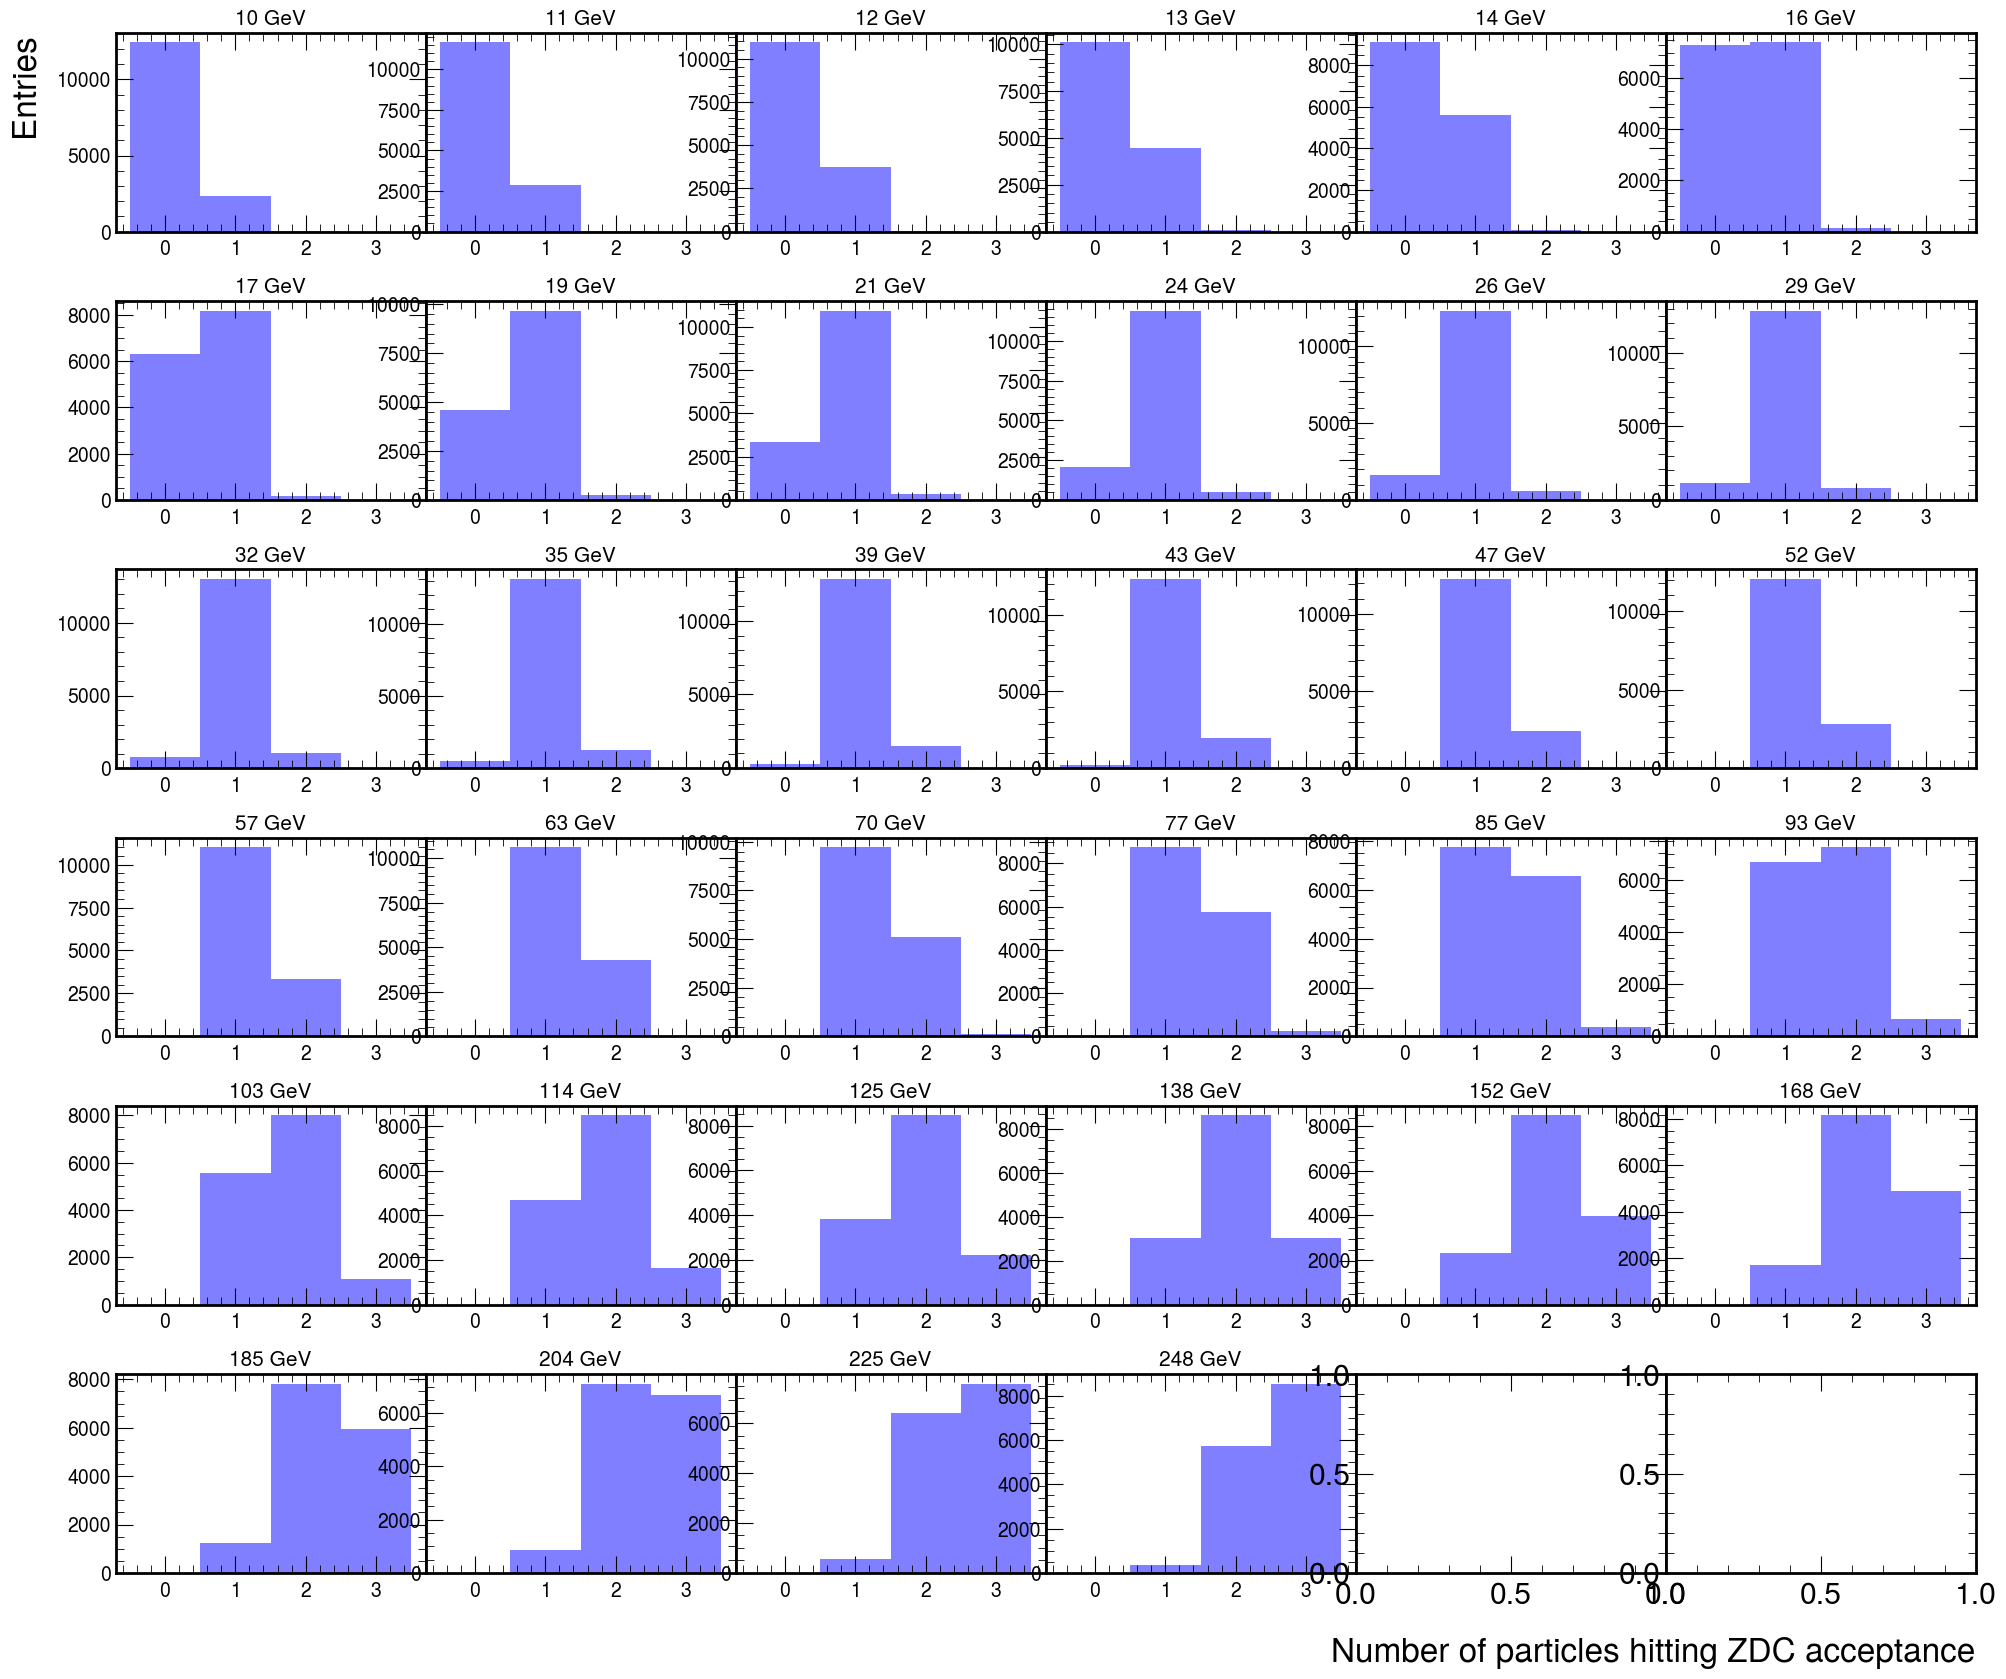

In [6]:
fraction_three_particle_events, fraction_two_particle_events, fraction_one_particle_events, fraction_zero_particle_events = plot_num_particles(event_genP,
                                                                                                                                               num_particles_in_zdc,
                                                                                                                                               energy_bins)

Text(0.5, 1.0, '$\\Lambda \\rightarrow n + \\pi^0: 10-250~GeV$ efficiency')

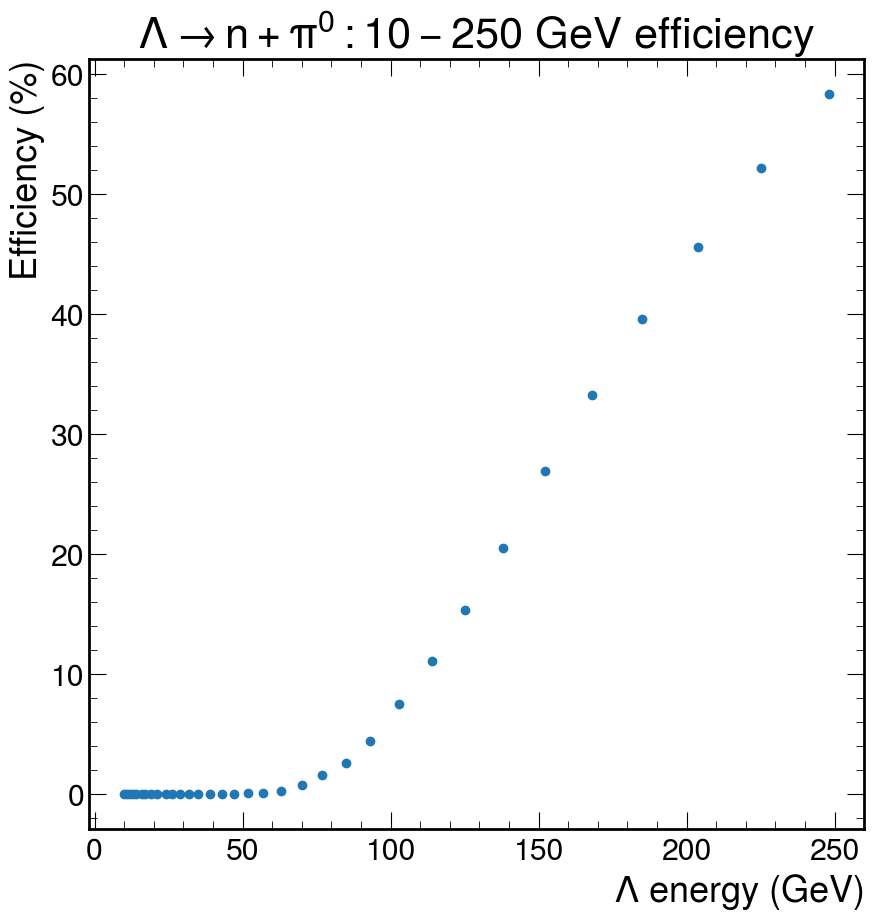

In [7]:
plt.scatter(energy_bins, fraction_three_particle_events*100.)
plt.xlabel("$\Lambda$ energy (GeV)")
plt.ylabel("Efficiency (%)")
plt.title(r"$\Lambda \rightarrow n + \pi^0: 10-250~GeV$ efficiency") 